# Module

In [1]:
import random
import numpy as np
from colorama import Fore, Style
import matplotlib.pyplot as plt


# Grid Board

In [2]:
class GridWorld:

    def __init__(self):
        self.grid_size = 6
        self.initial_wumpus_locations = []
        self.setup_grid()

    def setup_grid(self):
        self.grid = [[[] for _ in range(self.grid_size)] for _ in range(self.grid_size)]
        self.wumpus_locations = []
        
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                self.grid[i][j] = []

        self.grid[1][1].append('Safe')
        self.grid[4][4].append('Gold')
        self.add_glitter(4, 4)

        for i in range(1, self.grid_size - 1):
            for j in range(1, self.grid_size - 1):
                if (i, j) not in [(1, 1), (4, 4)]:
                    if np.random.rand() < 0.1:
                        self.grid[i][j].append('Pit')
                        self.add_breeze(i, j)
                    elif np.random.rand() < 0.1:
                        self.grid[i][j].append('Wumpus')
                        self.add_stench(i, j)
                        self.wumpus_locations.append((i, j))
                        self.initial_wumpus_locations.append((i, j))

        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if i == 0 or i == self.grid_size - 1 or j == 0 or j == self.grid_size - 1:
                    self.grid[i][j] = ['~~~']

    def add_breeze(self, x, y):
        for i, j in [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]:
            if 0 <= i < self.grid_size and 0 <= j < self.grid_size and '~~~' not in self.grid[i][j]:
                self.grid[i][j].append('Br')

    def add_glitter(self, x, y):
        for i, j in [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]:
            if 0 <= i < self.grid_size and 0 <= j < self.grid_size and '~~~' not in self.grid[i][j]:
                self.grid[i][j].append('G')

    def del_glitter(self, x, y):
        for i, j in [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]:
            if 0 <= i < self.grid_size and 0 <= j < self.grid_size and '~~~' not in self.grid[i][j]:
                if 'G' in self.grid[i][j]:
                    self.grid[i][j].remove('G')

    def add_stench(self, x, y):
        for i, j in [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]:
            if 0 <= i < self.grid_size and 0 <= j < self.grid_size and '~~~' not in self.grid[i][j]:
                if 'S' not in self.grid[i][j]:  # 중복 추가 방지 조건
                    self.grid[i][j].append('S')


    def del_stench(self, x, y):
        for i, j in [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]:
            if 0 <= i < self.grid_size and 0 <= j < self.grid_size and '~~~' not in self.grid[i][j]:
                if 'S' in self.grid[i][j]:  # 조건 수정
                    self.grid[i][j].remove('S')
                    


    def reset_grid(self):
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if 'Agent' in self.grid[i][j]:
                    self.grid[i][j].remove('Agent')
                if 'Wumpus' in self.grid[i][j]:
                    self.grid[i][j].remove('Wumpus')
                if 'S' in self.grid[i][j]:
                    self.grid[i][j].remove('S')

        self.wumpus_locations = []
        for wumpus_x, wumpus_y in self.initial_wumpus_locations:
            self.grid[wumpus_x][wumpus_y].append('Wumpus')
            self.add_stench(wumpus_x, wumpus_y)
            self.wumpus_locations.append((wumpus_x, wumpus_y))

    def print_grid(self, agent_x=None, agent_y=None, step=None):
        if step is not None:
            print(f"Step: {step}")

        cell_width = 14
        horizontal_line = "-" * (self.grid_size * (cell_width + 1) + 1)

        for i, row in enumerate(self.grid):
            print(horizontal_line)
            for j, cell in enumerate(row):
                if agent_x == i and agent_y == j:
                    cell_content = Fore.GREEN + 'Agent'.center(cell_width) + Style.RESET_ALL
                elif not cell:
                    cell_content = 'None'.center(cell_width)
                elif 'Wumpus' in cell:
                    cell_content = Fore.MAGENTA + ','.join(cell).center(cell_width) + Style.RESET_ALL
                elif 'Pit' in cell:
                    cell_content = Fore.RED + ','.join(cell).center(cell_width) + Style.RESET_ALL
                elif 'Gold' in cell:
                    cell_content = Fore.YELLOW + ','.join(cell).center(cell_width) + Style.RESET_ALL
                else:
                    cell_content = ','.join(cell).center(cell_width)
                print("|" + cell_content, end="")
            print("|")
        print(horizontal_line + "\n")

# Q-learning Agent

In [3]:
class QLearningAgent:

    def __init__(self, grid_size, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.grid_size = grid_size
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((grid_size, grid_size, 4))  # 이동 행동용 Q-테이블
        self.shoot_q_table = np.zeros((grid_size, grid_size, 4))  # 슈팅 행동용 Q-테이블
        self.actions = ['up', 'down', 'left', 'right', 'shoot_up', 'shoot_down', 'shoot_left', 'shoot_right']
        self.initial_arrows = 2
        self.arrows = self.initial_arrows
        self.has_gold = False  # 금을 가지고 있는지 여부를 추적하는 변수
        self.shoot_once = False  # 슈팅 행동 여부를 나타내는 플래그

    def choose_action(self, state, stench=False):
        x, y = state
        if stench and not self.shoot_once:
            self.shoot_once = True
            if np.random.rand() < self.epsilon:
                return random.choice(self.actions[4:])  # 랜덤하게 슈팅 행동 선택
            else:
                q_values = self.shoot_q_table[x, y]
                return self.actions[4:][np.argmax(q_values)]  # 가장 높은 Q 값을 가진 슈팅 행동 선택
        else:
            self.shoot_once = False
            if np.random.rand() < self.epsilon:
                return random.choice(self.actions[:4])  # 랜덤하게 이동 행동 선택
            else:
                q_values = self.q_table[x, y]
                return self.actions[:4][np.argmax(q_values)]  # 가장 높은 Q 값을 가진 이동 행동 선택

    def update_q_value(self, state, action, reward, next_state):
        x, y = state
        x_next, y_next = next_state
        action_index = self.actions.index(action)
        if action.startswith('shoot'):
            q_table = self.shoot_q_table
            action_index -= 4  # 슈팅 행동의 인덱스 조정
        else:
            q_table = self.q_table

        # 경계 조건 체크
        if x_next == 0 or x_next == self.grid_size or y_next == 0 or y_next == self.grid_size:
            return

        best_next_action = np.argmax(q_table[x_next, y_next])
        td_target = reward + self.gamma * q_table[x_next, y_next, best_next_action]
        td_error = td_target - q_table[x, y, action_index]
        q_table[x, y, action_index] += self.alpha * td_error

    def take_action(self, world, state, action, bump_count, wumpus_kill_count, print_scream=False):
        x, y = state
        new_x, new_y = x, y

        if action == 'up':
            new_x = x - 1  # 위로 이동
        elif action == 'down':
            new_x = x + 1  # 아래로 이동
        elif action == 'left':
            new_y = y - 1  # 왼쪽으로 이동
        elif action == 'right':
            new_y = y + 1  # 오른쪽으로 이동
        elif action.startswith('shoot'):
            next_state, reward, wumpus_kill_count = self.shoot(world, state, action, wumpus_kill_count, print_scream)
            return next_state, reward, bump_count, wumpus_kill_count

        if new_x == 0 or new_x == self.grid_size - 1 or new_y == 0 or new_y == self.grid_size - 1:
            bump_count += 1  # 벽에 부딪힘
            return state, -1, bump_count, wumpus_kill_count

        x, y = new_x, new_y

        reward = self.get_reward(world, x, y)  # 새로운 위치에서 보상 획득
        return (x, y), reward, bump_count, wumpus_kill_count

    def shoot(self, world, state, action, wumpus_kill_count, print_scream):
        if self.arrows == 0:  # 화살이 없으면
            return state, 0, wumpus_kill_count

        self.arrows -= 1  # 화살 한 개 사용
        x, y = state

        if action == 'shoot_up':
            if x > 0 and 'Wumpus' in world.grid[x - 1][y]:  # 위쪽에 움퍼스가 있는지 확인
                world.grid[x - 1][y].remove('Wumpus')  # Wumpus 제거
                world.del_stench(x - 1, y)  # Stench 제거
                wumpus_kill_count += 1
                if print_scream:
                    print('shoot up!!')
                    print("Wumpus scream!")  # Wumpus의 비명 출력
                return state, 30, wumpus_kill_count

        elif action == 'shoot_down':
            if x < world.grid_size - 1 and 'Wumpus' in world.grid[x + 1][y]:  # 아래쪽에 움퍼스가 있는지 확인
                world.grid[x + 1][y].remove('Wumpus')
                world.del_stench(x + 1, y)
                wumpus_kill_count += 1
                if print_scream:
                    print('shoot down!!')
                    print("Wumpus scream!")
                return state, 30, wumpus_kill_count

        elif action == 'shoot_left':
            if y > 0 and 'Wumpus' in world.grid[x][y - 1]:  # 왼쪽에 움퍼스가 있는지 확인
                world.grid[x][y - 1].remove('Wumpus')
                world.del_stench(x, y - 1)
                wumpus_kill_count += 1
                if print_scream:
                    print('shoot left!!')
                    print("Wumpus scream!")
                return state, 30, wumpus_kill_count

        elif action == 'shoot_right':
            if y < world.grid_size - 1 and 'Wumpus' in world.grid[x][y + 1]:  # 오른쪽에 움퍼스가 있는지 확인
                world.grid[x][y + 1].remove('Wumpus')
                world.del_stench(x, y + 1)
                wumpus_kill_count += 1
                if print_scream:
                    print('shoot right!!')
                    print("Wumpus scream!")
                return state, 30, wumpus_kill_count

        return state, -2, wumpus_kill_count  # 화살이 Wumpus를 맞추지 못한 경우

    def get_reward(self, world, x, y):
        if 'Wumpus' in world.grid[x][y]:
            return -50
        elif 'Pit' in world.grid[x][y]:
            return -50
        elif 'Gold' in world.grid[x][y]:
            self.has_gold = True  # 금을 먹었음을 표시
            world.grid[x][y].remove('Gold')
            world.del_glitter(x, y)
            return 50
        else:
            return -5




    def learn(self, world, episodes=100):
        print("Initial Grid:")
        world.print_grid()
        
        # 데이터를 저장할 리스트 초기화
        rewards = []
        bumps = []
        steps_list = []
        wumpus_kills = []
        
        for episode in range(episodes):
            state = (1, 1)
            self.arrows = self.initial_arrows
            self.has_gold = False  # 에피소드 시작 시 금 보유 상태 초기화
            total_reward = 0
            steps = 0
            bump_count = 0
            wumpus_kill_count = 0
            world.reset_grid()  # 에피소드 시작 시 매번 그리드를 초기 상태로 리셋
            while True:
                stench = 'S' in world.grid[state[0]][state[1]]
                action = self.choose_action(state, stench)
                next_state, reward, bump_count, wumpus_kill_count = self.take_action(world, state, action, bump_count, wumpus_kill_count)
                self.update_q_value(state, action, reward, next_state)
                state = next_state
                total_reward += reward
                steps += 1
                if self.has_gold:  # 금을 먹고 보상이 50 이상인 경우
                    print(f"Episode {episode + 1}: Total Reward: {total_reward}, Steps: {steps}, Bumps: {bump_count}, Wumpus Kills: {wumpus_kill_count}")
                    world.grid[4][4].append('Gold')
                    world.add_glitter(4, 4)
                    break
                elif 'Wumpus' in world.grid[state[0]][state[1]] or 'Pit' in world.grid[state[0]][state[1]] or total_reward <= -100:
                    # Wumpus나 Pit에 도달했을 때
                    self.has_gold = False
                    world.reset_grid()
                    state = (1, 1)
                    self.arrows = self.initial_arrows
                    total_reward = 0  # total_reward 초기화
                    steps = 0
                    bump_count = 0
                    wumpus_kill_count = 0
            
            # 에피소드 종료 후 데이터를 리스트에 저장
            rewards.append(total_reward)
            bumps.append(bump_count)
            steps_list.append(steps)
        
        # 에피소드가 끝난 후 그래프 작성
        episodes_range = range(1, episodes + 1)
        
        plt.figure(figsize=(14, 10))
    
        plt.subplot(3, 2, 1)
        plt.plot(episodes_range, rewards)
        plt.title('Total Rewards per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        
        plt.subplot(3, 2, 2)
        plt.plot(episodes_range, bumps, color='orange')
        plt.title('Bumps per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Bumps')
    
        plt.subplot(3, 2, 3)
        plt.plot(episodes_range, steps_list, color='green')
        plt.title('Steps per Episode')
        plt.xlabel('Episode')
        plt.ylabel('Steps')
    

        plt.subplot(3, 2, (5, 6))
        plt.plot(episodes_range, rewards, label='Rewards')
        plt.plot(episodes_range, bumps, label='Bumps')
        plt.plot(episodes_range, steps_list, label='Steps')
        plt.title('All Metrics per Episode')
        plt.xlabel('Episode')
        plt.legend()
    
        plt.tight_layout()
        plt.show()





    def reverse_action(self,action):
        action_map = {
            'up': 'down',
            'down': 'up',
            'left': 'right',
            'right': 'left',
            'shoot_up': 'shoot_down',
            'shoot_down': 'shoot_up',
            'shoot_left': 'shoot_right',
            'shoot_right': 'shoot_left'
        }
        return action_map.get(action, action)

    def test_agent(self, world):
        state = (1, 1)
        step = 0
        total_reward = 0
        bump_count = 0
        wumpus_kill_count = 0
        self.arrows = self.initial_arrows
        self.has_gold = False  # 테스트 시작 시 금 보유 상태 초기화
        self.shoot_once = False  # 슈팅 행동 초기화
        world.reset_grid()
        
        actions_taken = []  # agent가 수행한 행동을 추적하는 리스트
        
        while state != (4, 4):
            world.print_grid(agent_x=state[0], agent_y=state[1], step=step)
            stench = 'S' in world.grid[state[0]][state[1]]
            
            if stench and not self.shoot_once:
                action = self.actions[4 + np.argmax(self.shoot_q_table[state[0], state[1]])]  # 슈팅 Q-테이블에서 행동 선택
            else:
                action = self.actions[np.argmax(self.q_table[state[0], state[1]])]  # 이동 Q-테이블에서 행동 선택
            
            next_state, reward, bump_count, wumpus_kill_count = self.take_action(world, state, action, bump_count, wumpus_kill_count, print_scream=True)
            total_reward += reward
            state = next_state
            step += 1
            actions_taken.append(action)  # 수행한 행동을 저장
            print('reward:', total_reward)
            print('')
            print('')
            
            if 'Wumpus' in world.grid[state[0]][state[1]] or 'Pit' in world.grid[state[0]][state[1]]:
                # Wumpus나 Pit에 도달했을 때
                print(f"Agent died at step {step}. Total Reward: {total_reward}, Bumps: {bump_count}, Wumpus Kills: {wumpus_kill_count}")
                break
            
            if self.has_gold:
                world.print_grid(agent_x=state[0], agent_y=state[1], step=step)
                print(f"Agent grabed the gold! Total Reward: {total_reward}, Steps: {step}, Bumps: {bump_count}, Wumpus Kills: {wumpus_kill_count}")                
                break  # 금을 찾았으면 종료
        
        # 금을 찾은 후에 (1, 1)로 돌아가기
        if self.has_gold:
            actions_taken.reverse()  # 수행한 행동을 역순으로
            state = (4, 4)  # gold를 찾은 위치에서 시작
            for action in actions_taken:
                if 'shoot' in action:
                    continue  # shoot 관련 action은 무시
                reverse_action = self.get_reverse_action(action)  # 반대 행동 계산
                next_state, _, bump_count, wumpus_kill_count = self.take_action(world, state, reverse_action, bump_count, wumpus_kill_count, print_scream=False)
                state = next_state
                step += 1
                world.print_grid(agent_x=state[0], agent_y=state[1], step=step)
                
                if state == (1, 1):
                    print(f"Agent climbed!!! Total Reward: {total_reward}, Steps: {step}, Bumps: {bump_count}, Wumpus Kills: {wumpus_kill_count}")
                    break

    def get_reverse_action(self, action):
        reverse_action_dict = {
            'up': 'down',
            'down': 'up',
            'left': 'right',
            'right': 'left'
        }
        return reverse_action_dict.get(action, action)  # shoot 관련 action은 그대로 반환


# QLearningAgent 클래스에 test_agent 메서드 추가

# Main

In [4]:
if __name__ == "__main__":
    world = GridWorld()
    agent = QLearningAgent(world.grid_size)
    world.print_grid()

-------------------------------------------------------------------------------------------
|     ~~~      |     ~~~      |     ~~~      |     ~~~      |     ~~~      |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |     Safe     |      S       |     None     |     None     |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |      S       |   Wumpus,S   |      S       |     None     |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |      S       |   S,Wumpus   |      S       |      G       |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |     None     |      S       |      G       |     Gold     |     ~~~      |
--------------------------------------------------------------------------------

# Check Q-tables

Initial Grid:
-------------------------------------------------------------------------------------------
|     ~~~      |     ~~~      |     ~~~      |     ~~~      |     ~~~      |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |     Safe     |     None     |     None     |     None     |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |     None     |     None     |     None     |     None     |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |     None     |     None     |     None     |      G       |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |     None     |     None     |      G       |     Gold     |     ~~~      |
------------------------------------------------------------------

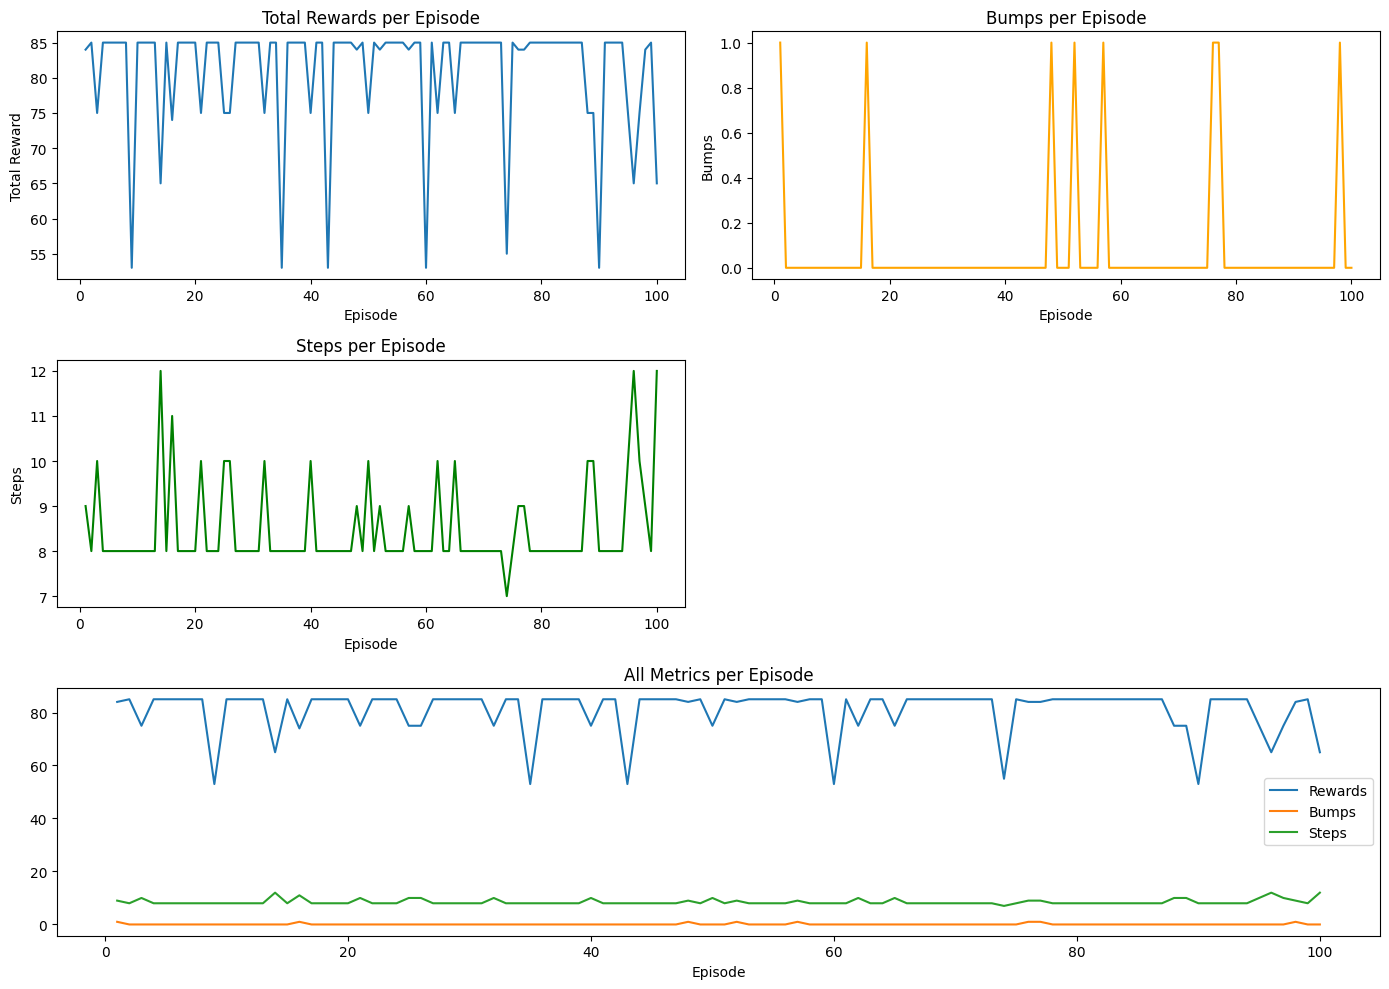

Step: 0
-------------------------------------------------------------------------------------------
|     ~~~      |     ~~~      |     ~~~      |     ~~~      |     ~~~      |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |    Agent     |      S       |     None     |     None     |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |      S       |   Wumpus,S   |      S       |     None     |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |      S       |   S,Wumpus   |      S       |      G       |     ~~~      |
-------------------------------------------------------------------------------------------
|     ~~~      |     None     |      S       |      G       |     Gold     |     ~~~      |
------------------------------------------------------------------------

In [10]:
    agent.learn(world)
    agent.test_agent(world)

In [6]:
# 주어진 그리드 좌표
x = 2
y = 1

# 각 행동에 대한 레이블
action_labels = ['up', 'down', 'left', 'right', 'shoot_up', 'shoot_down', 'shoot_left', 'shoot_right']

# Q-테이블에서 이동 행동에 대한 Q-값을 추출
move_q_values = agent.q_table[x][y]
# Q-테이블에서 슈팅 행동에 대한 Q-값을 추출
shoot_q_values = agent.shoot_q_table[x][y]

# 출력 형식을 만들고 각 행동에 대한 확률을 포맷하여 추가합니다.
output_string = "Action label\n"
output_string += "\n".join([f"{label}: {prob:.3f}" for label, prob in zip(action_labels[:4], move_q_values)])

output_string += "\n\nShoot Action label\n"
output_string += "\n".join([f"{label}: {prob:.3f}" for label, prob in zip(action_labels[4:], shoot_q_values)])

# 결과를 출력합니다.
print(output_string)


Action label
up: -9.016
down: -8.702
left: -8.618
right: 0.069

Shoot Action label
shoot_up: 9.964
shoot_down: -0.200
shoot_left: 2.626
shoot_right: 101.315


In [7]:
optimal_actions = []

# 1부터 4까지의 그리드 좌표에서 최적 행동을 추출합니다.
for i in range(1, 5):
    for j in range(1, 5):
        move_q_values = agent.q_table[i][j]
        shoot_q_values = agent.shoot_q_table[i][j]
        
        # 이동과 슈팅 Q-값을 합쳐서 최적 행동을 찾습니다.
        combined_q_values = np.concatenate((move_q_values, shoot_q_values))
        max_action_index = np.argmax(combined_q_values)
        optimal_actions.append(agent.actions[max_action_index])  # 최적 행동을 추가

# 출력 형식을 생성합니다.
output_string = "Optimal Actions in the Grid:\n"
for i in range(4):
    for j in range(4):
        output_string += f"{optimal_actions[i*4 + j]:<12}"  # 그리드 형식으로 정렬하여 출력
    output_string += "\n"


# 결과를 출력합니다.
print(output_string)


Optimal Actions in the Grid:
right       shoot_down  down        down        
shoot_right shoot_down  right       down        
shoot_right down        right       down        
shoot_up    right       right       up          


In [8]:
optimal_actions = []

# 1부터 4까지의 그리드 좌표에서 최적 행동을 추출합니다.
for i in range(1, 5):
    for j in range(1, 5):
        move_q_values = agent.q_table[i][j]
        shoot_q_values = agent.shoot_q_table[i][j]
        
        # 이동과 슈팅 Q-값을 합쳐서 최적 행동을 찾습니다.
        #combined_q_values = np.concatenate((move_q_values, shoot_q_values))
        max_action_index = np.argmax(move_q_values)
        optimal_actions.append(agent.actions[max_action_index])  # 최적 행동을 추가

# 출력 형식을 생성합니다.
output_string = "Move Actions in the Grid:\n"
for i in range(4):
    for j in range(4):
        output_string += f"{optimal_actions[i*4 + j]:<12}"  # 그리드 형식으로 정렬하여 출력
    output_string += "\n"

# 결과를 출력합니다.
print(output_string)


Move Actions in the Grid:
right       down        down        down        
right       right       right       down        
left        down        right       down        
right       right       right       up          


In [9]:
import numpy as np

optimal_actions = []
shoot_label = ['shoot_up', 'shoot_down', 'shoot_left', 'shoot_right']

# 1부터 4까지의 그리드 좌표에서 최적 행동을 추출합니다.
for i in range(1, 5):
    for j in range(1, 5):
        shoot_q_values = agent.shoot_q_table[i][j]
        
        # 모든 shoot_q_values가 0인지 확인합니다.
        if np.all(shoot_q_values == 0):
            optimal_actions.append('NaN')
        else:
            # 슈팅 Q-값을 이용하여 최적 행동을 찾습니다.
            max_action_index = np.argmax(shoot_q_values)
            optimal_actions.append(shoot_label[max_action_index])  # 최적 행동을 추가

# 출력 형식을 생성합니다.
output_string = "Shoot Actions in the Grid:\n"
for i in range(4):
    for j in range(4):
        output_string += f"{optimal_actions[i * 4 + j]:<12}"  # 그리드 형식으로 정렬하여 출력
    output_string += "\n"

# 결과를 출력합니다.
print(output_string)


Shoot Actions in the Grid:
NaN         shoot_down  NaN         NaN         
shoot_right shoot_down  NaN         NaN         
shoot_right NaN         shoot_left  NaN         
NaN         NaN         NaN         NaN         
